# All settings will be given to the channel 1 output, in the DC Amp out configuration

In [102]:
%matplotlib inline 

In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib
import matplotlib.pyplot as plt
import pyvisa as visa
from matplotlib import animation
from matplotlib.animation import FuncAnimation
#Importing the functions from the module and the pulses dictionaries
from Sweeping import *
from Dictionaries import *
from PulseFiles import *
from Instrument import * 

# Visa interface for the M8190A instrument:

In [2]:
M8190A = VisaR(AWG_S1,60000)
Init(M8190A,AWG_S1)

Instruments Sampling Frecuency set to 1.25000000000000E+08Hz
Instruments DC1 Output Voltage set to 3.00000000000000E-01deciVolts


In [4]:
M8190A.write('*RST')

5

In [5]:
Init(M8190A,AWG_S1)

Instruments Sampling Frecuency set to 1.25000000000000E+08Hz
Instruments DC1 Output Voltage set to 3.00000000000000E-01deciVolts


In [4]:
print(M8190A)

TCPIPInstrument at TCPIP0::ibn3-036.ibn-net.kfa-juelich.de::hislip0::INSTR


# Quering Instrument Settings

In [81]:
#Understanding the structure of the SEQ:DATA command

#M8190A.write('[:SOURce]:SEQuence[1|2]:DATA <sequence_id>,<step>,[<value>,<value>,…|<data block>] <segment_id>, <loop_count>,<advance_mode>,<marker_enable>, <start_addr>,<end_addr>

#M8190A.query('[:SOURce]:SEQuence[1|2]:DATA? <sequence_id>,<step>,<length>')

#<advance_mode> 0: AUTO, 1: CONDitional, 2: REPeat, 3: SINGle. Specifies how the generator advances from one sequence table entry to the next one.

In [8]:
M8190A.query('SYST:ERR?')

'0,"No error"'

# Marker Subsystem

Import the marker sample data through cvs with the following order:

" M8190A User’s Guide 287
CSV

_ Normalized values (-1.0 .. +1.0) and markers in comma delimited format. The file can contain either 1 (waveform data for channel 1), 2 (waveform data for channel 1 & 2), 3 (waveform data, sample marker, sync marker for channel 1) or 6 (waveform data, sample marker, sync marker for channel 1 and 2) columns. If the file contains data for two channels, it will be treated as IQ file._

While trying to write a sinus function throught the marker channel:

_"-300,"Device-specific error;CH1: Error in file ""Puls1.csv""(line: 1): Marker data ""-1.00E-10"" is not valid. Marker data can be either 1 or 0."'"_


# Sequence for a 100 Hz marker syncronization

## Sync clock / Sequencer Clock

The data generation consists of a Sample Memory which contains the sample data, a Sequence Memory which contains the required information for sequencing like the sequence structure or loop counter values and a Channel FPGA which combines both into a sequence controlled sample stream. These parts cannot run at sample clock rate and therefore multiple samples must be executed in parallel at a lower clock speed. **Depending on the selected direct mode, the Sync Clock, also called Sequencer Clock is the sample clock divided by 64 (high speed mode) or by 48 (high precision mode)**. When using the interpolated modes (refer to the chapter Digital Up-Conversion), one Sync Clock cycle covers 24 delivered (not interpolated) IQ sample pairs. Therefore, a sync clock cycle consists of “24*interpolation factor” DAC samples.
The DAC converts the parallel sample stream to sample clock granularity. The analog output of the DAC can either be used directly at the DIRECT OUT pin or can be routed through two different available amplifier paths.

3.1.3 Sequencer Granularity

The sequencer is running at a lower clock speed than the sample rate of the instrument.
Therefore the sequencer has to play multiple samples within one sync clock cycle.
The number of samples played within one sync clock cycle is called sequencer
granularity or segment granularity. For details, refer to the block diagram in section


## Instrument Settings:


## Creating the Segments with the Sweep code

In [41]:
M8190A.query('SYST:ERR?')

'-300,"Device-specific error;CH1: Segment id 4 is not defined."'

## Initializing the sequences

Depending on the selected direct mode, the Sync Clock, also called Sequencer Clock is the sample clock divided by 64 (high speed mode) or by 48 (high precision mode)

# ROLE MODEL

In [7]:
Pulses_List

[{'Name': 'Rabi',
  'Amplitude': 200,
  'Start time': 1e-10,
  'End time': 2e-10,
  'Start Duration': 1,
  'End Duration': 6,
  'Sweep time': 0,
  'Sweep Duration': 0},
 {'Name': 'Probe1',
  'Amplitude': 50,
  'Start time': 1,
  'End time': 4,
  'Start Duration': 1,
  'End Duration': 9,
  'Sweep time': 1,
  'Sweep Duration': 0}]

In [7]:
M8190A.write('TRAC:DWID WPR')

14

In [5]:
M8190A.query('SEQ:CAT?')

'0,2,2,2'

Sampling frecuency has some effect with the segmentation for the sequences, changing it from 125Mhz to 1Ghz made it so 6 repetitions of the segments transform into 3. Still have to play with this.

tomorrow: do a run with the 7.2 GHz sample rate and see if I get individual segments per sequences, as desired

In [34]:
M8190A.query('ROSC:SOUR:CHEC? INT')

'1'

In [40]:
M8190A.query('STAT:QUES:SEQ?')

'0'

### Animation

In [22]:
%matplotlib notebook
plt.style.use('seaborn-pastel')
fig = plt.figure()
ax = plt.axes(xlim=(-1, 32), ylim=(0, 11))
ax.grid(True)
ax.set_ylabel('V  [mV]')
ax.set_xlabel('t  [s]')
line, = ax.plot([], [], color='black')

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return line,

# animation function.  We iterate over p and define the stopping point by the end value of frames in the anim function
def animate(i):
    y, time = Sweep(Pulses_List,100,i,32,1000)
    line.set_data(time, y)
    return line,

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,frames=np.linspace(0,100), interval=400, blit=True)
plt.show()

#in our case, frames should match to the total number of time steps P

<IPython.core.display.Javascript object>

# Misc. SCPI commands

In [ ]:
M8190A.query('SEQ:FREE?')

In [ ]:
M8190A.query('FUNC1:MODE?')

In [110]:
M8190A.query('MMEM:CAT?')

'117502717952,381959192576,"desktop.ini,,402","M8190A Queries.xlsx,,9966","[Custom Office Templates],,","[GitHub],,","[Keysight],,","[My Music],,","[My Pictures],,","[My Videos],,","[Notebooks],,","[Python Scripts],,","[Remote Assistance Logs],,"'

In [109]:
M8190A.query('SYST:SET?')

'#45950<setting type="setup"><pin name="CHANNEL 1"><attribute name="ArmMode" value="0" /><attribute name="CarrierFrequencyFractional" value="0" /><attribute name="CarrierFrequencyIntegral" value="2000000000" /><attribute name="CarrierPhaseOffset" value="0" /><attribute name="CarrierScale" value="1" /><attribute name="ChannelDelay" value="0" /><attribute name="ChannelDelayCoarse" value="0" /><attribute name="ChannelsCoupled" value="0" /><attribute name="ContinuousMode" value="1" /><attribute name="DisableHwDynamicSelect" value="0" /><attribute name="DisableHwEnable" value="0" /><attribute name="DisableHwEvent" value="0" /><attribute name="DisableHwTrigger" value="0" /><attribute name="DynamicSelect" value="0" /><attribute name="EnableMarker" value="1" /><attribute name="FunctionMode" value="1" /><attribute name="GatedMode" value="0" /><attribute name="OutputBalance" value="0" /><attribute name="OutputNormalState" value="1" /><attribute name="OutputRoute" value="1" /><attribute name="Red

In [87]:
M8190A.query('*OPC?') #this is for checking that the previous commands were completed

'1'

In [47]:
M8190A.write('*CLS')

5

In [22]:
M8190A.write('*RST') #Reseting the instrument to factory settings

5

In [98]:
M8190A.write('TRAC1:DEL:ALL') #Delets the stored segments in the instrument

14

In [133]:
M8190A.write('ABOR') #self explanatory

5

Sequences are visualized in Tables, each table entry corresponds to a segment.

Users Manaual page 251:

_"Sequences are made of a number of arbitrary waveforms, which can be linked and looped in user-programmable order. Sequences are generated from waveforms stored in the waveform memory as memory segments."_

A segment corresponds to a waveform (just one?), i.e. some sample data with a corresponding sampling rate frecuency.

:TRAC subsystem to generate segments ($\checkmark$)

:SEQ subsystem to generate sequences.

Trigger for seq A and advance for seq b ??

Internal Trigger Generator

reference oscillator


usual data loaded, internal frecuency set at 15 kHz, sequence is repeted after a time interval of roughly 52us, below this internal frecuency, there is only one sequence displayed.

Advancent/ event triggering due to internal clock related to marker syncronization?

In [42]:
M8190A.query('OUTP:ROUT?')

'DC'

# Pulse Segments for different $\Delta\tau$

In [4]:
start = time.time()

obo,tom = Tau(Pulses_List,10,13,625000,0,10)
obo2,tom = Tau(Pulses_List,10,13,625000,5,10)
obo3,tom = Tau(Pulses_List,10,13,625000,4,6)
#Data_Frames = TDF_CVS(obo,AWG_S1,'A')

end = time.time()

print(end - start)

61.24096941947937


In [5]:
15e-3*AWG_S1['Clock Sample Frecuency']

1875000.0

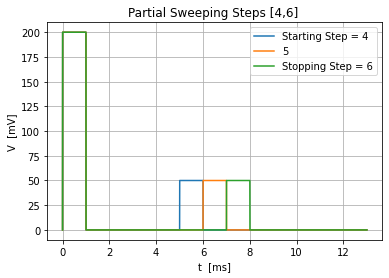

In [8]:
fig,ax= plt.subplots()

ax.grid(True)
plt.plot(tom,obo3[0],label= 'Starting Step = 4')
plt.plot(tom,obo3[1],label= '5')
plt.plot(tom,obo3[2],label= 'Stopping Step = 6')
#plt.plot(tom,obo[7],label= '8')
#plt.plot(tom,obo[8],label= '4')
#plt.plot(tom,obo[9],label= '5')
#plt.plot(tom,obo[10],label= '10')
ax.set_ylabel('V  [mV]')
ax.set_xlabel('t  [ms]')
ax.set_title('Partial Sweeping Steps [4,6] ')
ax.legend(loc=0)
plt.show()
#fig.savefig('Pulse_sweep_t=20',optimize=True,bbox_inches='tight')

In [7]:
Pulses_List

[{'Name': 'Rabi',
  'Amplitude': 200,
  'Start time': 1e-10,
  'End time': 2e-10,
  'Start Duration': 1,
  'End Duration': 6,
  'Sweep time': 0,
  'Sweep Duration': 0},
 {'Name': 'Probe1',
  'Amplitude': 50,
  'Start time': 1,
  'End time': 11,
  'Start Duration': 1,
  'End Duration': 9,
  'Sweep time': 1,
  'Sweep Duration': 0}]

In [13]:
obo3.shape

(2, 625000)

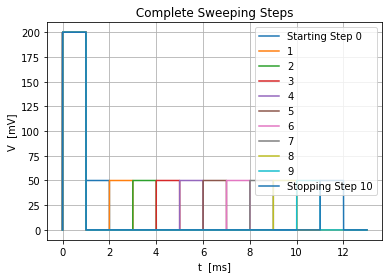

In [6]:
fig,ax= plt.subplots()

ax.grid(True)
plt.plot(tom,obo[0],label= 'Starting Step 0')
plt.plot(tom,obo[1],label= '1')
plt.plot(tom,obo[2],label= '2')
plt.plot(tom,obo[3],label= '3')
plt.plot(tom,obo[4],label= '4')
plt.plot(tom,obo[5],label= '5')
plt.plot(tom,obo[6],label= '6')
plt.plot(tom,obo[7],label= '7')
plt.plot(tom,obo[8],label= '8')
plt.plot(tom,obo[9],label= '9')
plt.plot(tom,obo[10],label= 'Stopping Step 10')
ax.set_ylabel('V  [mV]')
ax.set_xlabel('t  [ms]')
ax.set_title(' Complete Sweeping Steps ')
ax.legend(loc=0)
plt.show()
#fig.savefig('Pulse_sweep_t=20',optimize=True,bbox_inches='tight')

In [8]:
len(obo)

11

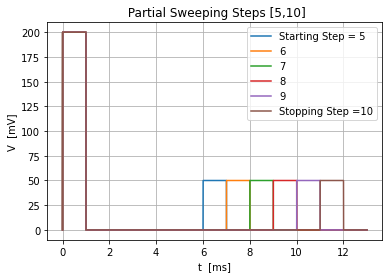

In [7]:
fig,ax= plt.subplots()

ax.grid(True)
plt.plot(tom,obo2[0],label= 'Starting Step = 5')
plt.plot(tom,obo2[1],label= '6')
plt.plot(tom,obo2[2],label= '7')
plt.plot(tom,obo2[3],label= '8')
plt.plot(tom,obo2[4],label= '9')
plt.plot(tom,obo2[5],label= 'Stopping Step =10')
#plt.plot(tom,obo[10],label= '10')
ax.set_ylabel('V  [mV]')
ax.set_xlabel('t  [ms]')
ax.set_title(' Partial Sweeping Steps [5,10]')
ax.legend(loc=0)
plt.show()
#fig.savefig('Pulse_sweep_t=20',optimize=True,bbox_inches='tight')

Maybe I should add a key to the AWG dictionaries that is the intended time length of the pulse, that way I could also rename the csv files relatively easy to inlcude this parameter for more data file clarity.

# Characterize for different samling frecuencies, time lengths, loops

## First, leaving the time length at 5ms per segment, single loop

In [4]:
5e-3*1.25e8

625000.0

In [11]:
M8190A.query('SYST:ERR?')

'0,"No error"'

## For a sampling frecuency of 125MHz

In [4]:
M8190A.query('FREQ:RAST?')

'7.20000000000000E+09'

In [3]:
#Pulse Sequence for sampling rate at 125Mhz, 5ms time length

start = time.time()

pl, tim= Sweept(Pulses_List,10,2,5,625000)
pln, tim= Sweept(Pulses_List2,10,2,5,625000)

SeqL(M8190A,pl,pln,AWG_S1,0,1)

end = time.time()

print(end - start)

Current Segment Catalogue is 1,3750000  [(segment id, Segment size)]
Current Segment Catalogue is 1,3750000,2,3750000  [(segment id, Segment size)]
Sequence loaded with the following segment data "1,1,0,1,0,3749999,2,1,0,1,0,3749999"
9.047144174575806


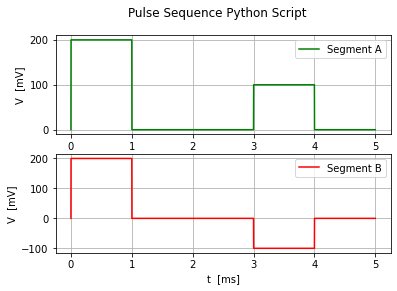

<ipython-input-6-a1a09df37a06>:19: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "optimize" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig('PulseSequence_5ms_125Mhz_step2',optimize=True,bbox_inches='tight')


In [6]:
fig,ax= plt.subplots(2)

ax[0].grid(True)
ax[1].grid(True)
fig.suptitle('Pulse Sequence Python Script')

ax[0].plot(tim,pl,'-g',label= 'Segment A')
ax[1].plot(tim,pln,'-r',label= 'Segment B')
ax[0].set_ylabel('V  [mV]')
ax[1].set_ylabel('V  [mV]')
ax[0].set_xlabel('t  [ms]')
ax[1].set_xlabel('t  [ms]')

#ax[0].set_title(' Pulse Sequence Python Script ')

ax[0].legend(loc=0)
ax[1].legend(loc=0)
plt.show()
fig.savefig('PulseSequence_5ms_125Mhz_step2',optimize=True,bbox_inches='tight')

In [5]:
M8190A.write('INIT:IMM')

9

In [7]:
M8190A.write('ABOR')

5

## For sampling frecuency 500Mhz

In [3]:
M8190A.write('FREQ:RAST 500000000')

20

In [4]:
M8190A.query('FREQ:RAST?')

'5.00000000000000E+08'

In [5]:
5e-3 * 500000000

2500000.0

In [6]:
#Pulse Sequence for sampling rate at 500Mhz, 5ms time length

start = time.time()

pl, tim= Sweept(Pulses_List,10,2,5,2500000)
pln, tim= Sweept(Pulses_List2,10,2,5,2500000)

SeqL(M8190A,pl,pln,AWG_S1,0,1)

end = time.time()

print(end - start)

Current Segment Catalogue is 1,7500000  [(segment id, Segment size)]
Current Segment Catalogue is 1,7500000,2,7500000  [(segment id, Segment size)]
Sequence loaded with the following segment data "1,1,0,1,0,7499999,2,1,0,1,0,7499999"
36.00245785713196


In [7]:
M8190A.write('INIT:IMM')

9

In [8]:
M8190A.write('ABOR')

5

## Sampling Frecuency for 1GHz

In [3]:
M8190A.write('FREQ:RAST 1000000000')

21

In [4]:
5e-3 * 1000000000

5000000.0

In [4]:
#Pulse Sequence for sampling rate at 1GHz, 5ms time length

start = time.time()

pl, tim= Sweept(Pulses_List,10,2,5,5000000)
pln, tim= Sweept(Pulses_List2,10,2,5,5000000)

SeqL(M8190A,pl,pln,AWG_S1,2,1)

end = time.time()

print(end - start)

Current Segment Catalogue is 1,15000000  [(segment id, Segment size)]
Current Segment Catalogue is 1,15000000,2,15000000  [(segment id, Segment size)]
Sequence loaded with the following segment data "1,1,0,1,0,14999999,2,1,0,1,0,14999999"
68.57545733451843


In [5]:
M8190A.write('INIT:IMM')

9

In [6]:
M8190A.write('ABOR')

5

## 5GHz

In [ ]:
M8190A.write('FREQ:RAST 5000000000')

In [7]:
5e-3 * 5000000000

25000000.0

In [5]:
#Pulse Sequence for sampling rate at 5GHz, 5ms time length

start = time.time()

pl, tim= Sweept(Pulses_List,10,2,5,25000000)
pln, tim= Sweept(Pulses_List2,10,2,5,25000000)

SeqL(M8190A,pl,pln,AWG_S1,2,1)

end = time.time()

print(end - start)

Current Segment Catalogue is 1,75000000  [(segment id, Segment size)]
Current Segment Catalogue is 1,75000000,2,75000000  [(segment id, Segment size)]
Sequence loaded with the following segment data "1,1,0,1,0,74999999,2,1,0,1,0,74999999"
345.4330532550812


In [6]:
M8190A.write('INIT:IMM')

9

In [7]:
M8190A.write('ABOR')

5

## 7.2GHz


In [3]:
M8190A.write('FREQ:RAST 7200000000')

21

In [4]:
5e-3 * 7200000000

36000000.0

In [5]:
#Pulse Sequence for sampling rate at 7.2GHz, 5ms time length

start = time.time()

pl, tim= Sweept(Pulses_List,10,2,5,36000000)
pln, tim= Sweept(Pulses_List2,10,2,5,36000000)

SeqL(M8190A,pl,pln,AWG_S1,2,1)

end = time.time()

print(end - start)

Current Segment Catalogue is 1,36000000  [(segment id, Segment size)]
Current Segment Catalogue is 1,36000000,2,36000000  [(segment id, Segment size)]
Sequence loaded with the following segment data "1,1,0,1,0,35999999,2,1,0,1,0,35999999"
493.06142115592957


In [6]:
M8190A.write('INIT:IMM')

9

In [7]:
M8190A.write('ABOR')

5

## Leaving Sample Frequency fixed at 500MHZ

In [3]:
M8190A.write('FREQ:RAST 500000000')

20

## 10ms

In [5]:

10e-3 * 500000000

5000000.0

In [4]:
#Pulse Sequence for sampling rate at 5MHz, 10ms time length

start = time.time()

pl, tim= Sweept(Pulses_List,10,2,10,5000000)
pln, tim= Sweept(Pulses_List2,10,2,10,5000000)

SeqL(M8190A,pl,pln,AWG_S1,2,1)

end = time.time()

print(end - start)

Current Segment Catalogue is 1,15000000  [(segment id, Segment size)]
Current Segment Catalogue is 1,15000000,2,15000000  [(segment id, Segment size)]
Sequence loaded with the following segment data "1,1,0,1,0,14999999,2,1,0,1,0,14999999"
68.24792194366455


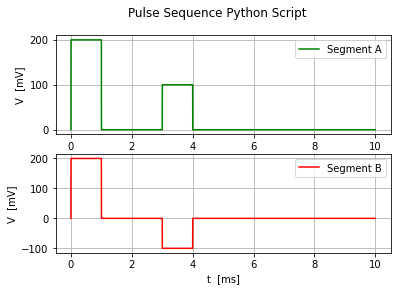

<ipython-input-5-c774aea6ca29>:19: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "optimize" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig('PulseSequence_10ms_500Mhz_step2',optimize=True,bbox_inches='tight')


In [5]:
fig,ax= plt.subplots(2)

ax[0].grid(True)
ax[1].grid(True)
fig.suptitle('Pulse Sequence Python Script')

ax[0].plot(tim,pl,'-g',label= 'Segment A')
ax[1].plot(tim,pln,'-r',label= 'Segment B')
ax[0].set_ylabel('V  [mV]')
ax[1].set_ylabel('V  [mV]')
ax[0].set_xlabel('t  [ms]')
ax[1].set_xlabel('t  [ms]')

#ax[0].set_title(' Pulse Sequence Python Script ')

ax[0].legend(loc=0)
ax[1].legend(loc=0)
plt.show()
fig.savefig('PulseSequence_10ms_500Mhz_step2',optimize=True,bbox_inches='tight')

In [6]:
M8190A.write('INIT:IMM')

9

In [7]:
M8190A.write('ABOR')

5

## 15ms

In [6]:
M8190A.write('FREQ:RAST 500000000')

20

In [8]:
15e-3*500000000

7500000.0

In [7]:
#Pulse Sequence for sampling rate at 5MHz, 15ms time length

start = time.time()

pl, tim= Sweept(Pulses_List,10,2,15,7500000)
pln, tim= Sweept(Pulses_List2,10,2,15,7500000)

SeqL(M8190A,pl,pln,AWG_S1,2,1)

end = time.time()

print(end - start)

Current Segment Catalogue is 1,7500000  [(segment id, Segment size)]
Current Segment Catalogue is 1,7500000,2,7500000  [(segment id, Segment size)]
Sequence loaded with the following segment data "1,1,0,1,0,7499999,2,1,0,1,0,7499999"
98.19244885444641


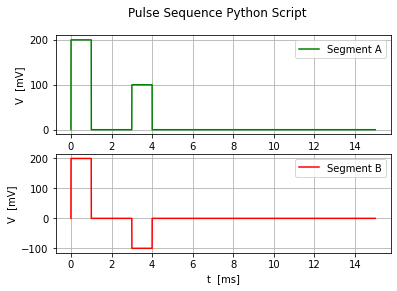

In [8]:
fig,ax= plt.subplots(2)

ax[0].grid(True)
ax[1].grid(True)
fig.suptitle('Pulse Sequence Python Script')

ax[0].plot(tim,pl,'-g',label= 'Segment A')
ax[1].plot(tim,pln,'-r',label= 'Segment B')
ax[0].set_ylabel('V  [mV]')
ax[1].set_ylabel('V  [mV]')
ax[0].set_xlabel('t  [ms]')
ax[1].set_xlabel('t  [ms]')

#ax[0].set_title(' Pulse Sequence Python Script ')

ax[0].legend(loc=0)
ax[1].legend(loc=0)
plt.show()
fig.savefig('PulseSequence_15ms_500Mhz_step2',optimize=True,bbox_inches='tight')

In [9]:
M8190A.write('INIT:IMM')

9

In [10]:
M8190A.write('ABOR')

5

## 13ms

In [5]:
M8190A.write('FREQ:RAST 500000000')

20

In [12]:
13e-3*5e8

6500000.0

In [3]:
#Pulse Sequence for sampling rate at 5MHz, 13ms time length

start = time.time()

pl, tim= Sweept(Pulses_List,10,2,13,6500000)
pln, tim= Sweept(Pulses_List2,10,2,13,6500000)

SeqL(M8190A,pl,pln,AWG_S1,2,1)

end = time.time()

print(end - start)

Current Segment Catalogue is 1,19500000  [(segment id, Segment size)]
Current Segment Catalogue is 1,19500000,2,19500000  [(segment id, Segment size)]
Sequence loaded with the following segment data "1,1,0,1,0,19499999,2,1,0,1,0,19499999"
89.16445398330688


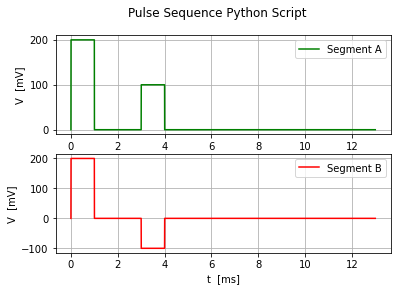

<ipython-input-4-f93c772913b7>:19: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "optimize" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig('PulseSequence_13ms_500Mhz_step2',optimize=True,bbox_inches='tight')


In [4]:
fig,ax= plt.subplots(2)

ax[0].grid(True)
ax[1].grid(True)
fig.suptitle('Pulse Sequence Python Script')

ax[0].plot(tim,pl,'-g',label= 'Segment A')
ax[1].plot(tim,pln,'-r',label= 'Segment B')
ax[0].set_ylabel('V  [mV]')
ax[1].set_ylabel('V  [mV]')
ax[0].set_xlabel('t  [ms]')
ax[1].set_xlabel('t  [ms]')

#ax[0].set_title(' Pulse Sequence Python Script ')

ax[0].legend(loc=0)
ax[1].legend(loc=0)
plt.show()
fig.savefig('PulseSequence_13ms_500Mhz_step2',bbox_inches='tight')

In [7]:
M8190A.write('INIT:IMM')

9

In [13]:
M8190A.write('ABOR')

5

## 20ms

In [3]:
M8190A.write('FREQ:RAST 500000000')

20

In [4]:
20e-3*5e8

10000000.0

In [5]:
#Pulse Sequence for sampling rate at 5MHz, 20ms time length

start = time.time()

pl, tim= Sweept(Pulses_List,10,2,20,10000000)
pln, tim= Sweept(Pulses_List2,10,2,20,10000000)

SeqL(M8190A,pl,pln,AWG_S1,2,1)

end = time.time()

print(end - start)

Current Segment Catalogue is 1,30000000  [(segment id, Segment size)]
Current Segment Catalogue is 1,30000000,2,30000000  [(segment id, Segment size)]
Sequence loaded with the following segment data "1,1,0,1,0,29999999,2,1,0,1,0,29999999"
139.0403709411621


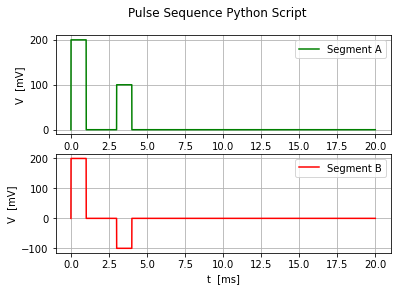

In [6]:
fig,ax= plt.subplots(2)

ax[0].grid(True)
ax[1].grid(True)
fig.suptitle('Pulse Sequence Python Script')

ax[0].plot(tim,pl,'-g',label= 'Segment A')
ax[1].plot(tim,pln,'-r',label= 'Segment B')
ax[0].set_ylabel('V  [mV]')
ax[1].set_ylabel('V  [mV]')
ax[0].set_xlabel('t  [ms]')
ax[1].set_xlabel('t  [ms]')

#ax[0].set_title(' Pulse Sequence Python Script ')

ax[0].legend(loc=0)
ax[1].legend(loc=0)
plt.show()
fig.savefig('PulseSequence_20ms_500Mhz_step2',bbox_inches='tight')

In [ ]:
M8190A.write('INIT:IMM')

In [8]:
M8190A.write('ABOR')

5

## Different Loop number

### 500Mhz,15ms

In [3]:
M8190A.write('FREQ:RAST 500000000')

20

In [4]:
#Pulse Sequence for sampling rate at 5MHz, 15ms time length

start = time.time()

pl, tim= Sweept(Pulses_List,10,2,15,7500000)
pln, tim= Sweept(Pulses_List2,10,2,15,7500000)

SeqL(M8190A,pl,pln,AWG_S1,2,3)

end = time.time()

print(end - start)

Current Segment Catalogue is 1,7500000  [(segment id, Segment size)]
Current Segment Catalogue is 1,7500000,2,7500000  [(segment id, Segment size)]
Sequence loaded with the following segment data "1,3,0,1,0,7499999,2,3,0,1,0,7499999"
99.674072265625


In [5]:
M8190A.write('INIT:IMM')


9

In [6]:
M8190A.write('ABOR')

5

### 5 loops

In [4]:
SeqF(M8190A,'D:\Alejandro\Pulses\Dict\SegmentA_7500000_2.csv','D:\Alejandro\Pulses\Dict\SegmentB_7500000_2.csv',5)

Sequence loaded with the following segment data "1,5,0,1,0,7499999,2,5,0,1,0,7499999"


0

# Plotting Oscilloscope readings

## NOTE: Here we are using that Sampling rate = Clock Sampling rate, when changing the sample frecuency within the software and seeing which SCPI command was used, it turns out it is one that changes the Clock Sampling rate. Sampling frecuency can be interpolated when importing "premade" waves. 

## 5ms fixed 

### 1GHz 

In [15]:
Ch1_1GHz = pd.read_csv(r'D:\OneDrive - rwth-aachen.de\RWTH\STM\Pulses\5ms fixed\1GHz\ALL0000\F0000CH1.csv')
Ch3_1GHz = pd.read_csv(r'D:\OneDrive - rwth-aachen.de\RWTH\STM\Pulses\5ms fixed\1GHz\ALL0000\F0000CH3.csv')

In [4]:
Ch1_1GHz

,Record Length,2.500000e+03,Unnamed: 2,0.000000000000,0.00400,Unnamed: 5
0,Sample Interval,2.000000e-05,NaN,0.00002,0.220,NaN
1,Trigger Point,0.000000000000e+00,NaN,0.00004,0.220,NaN
2,NaN,NaN,NaN,0.00006,0.224,NaN
3,NaN,NaN,NaN,0.00008,0.220,NaN
4,NaN,NaN,NaN,0.00010,0.220,NaN
...,...,...,...,...,...,...
2494,NaN,NaN,NaN,0.04990,0.004,NaN
2495,NaN,NaN,NaN,0.04992,0.004,NaN
2496,NaN,NaN,NaN,0.04994,0.004,NaN
2497,NaN,NaN,NaN,0.04996,0.004,NaN


In [12]:
Ch1_1GHz.iloc[:,4]

0       0.220
1       0.220
2       0.224
3       0.220
4       0.220
        ...  
2494    0.004
2495    0.004
2496    0.004
2497    0.004
2498    0.004
Name:    0.00400, Length: 2499, dtype: float64

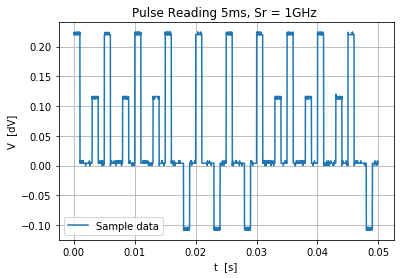

In [23]:
fig,ax= plt.subplots()

ax.grid(True)
plt.plot(Ch1_1GHz.iloc[:,3]*500,Ch1_1GHz.iloc[:,4],  label = 'Sample data')
#plt.plot(Ch3_1GHz.iloc[:,3]*500,Ch3_1GHz.iloc[:,4],label= 'Starting Step = 4')
ax.set_xlabel('t  [s]')
ax.set_ylabel('V  [dV]')
ax.set_title('Pulse Reading 5ms, Sr = 1GHz ')
ax.legend(loc=3)
plt.show()
#fig.savefig('Pulse_sweep_t=20',optimize=True,bbox_inches='tight')

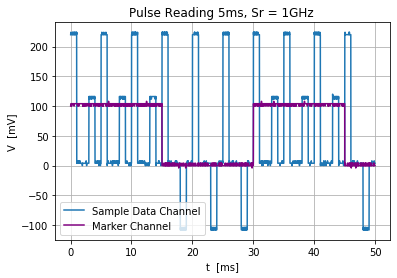

In [84]:
fig,ax= plt.subplots()

ax.grid(True)
plt.plot(Ch1_1GHz.iloc[:,3]*1000,Ch1_1GHz.iloc[:,4]*1000,label= 'Sample Data Channel')
plt.plot(Ch3_1GHz.iloc[:,3]*1000,Ch3_1GHz.iloc[:,4]*10,label= 'Marker Channel',color= 'purple')
ax.set_xlabel('t  [ms]')
ax.set_ylabel('V  [mV]')
ax.set_title('Pulse Reading 5ms, Sr = 1GHz ')
ax.legend(loc=3)
plt.show()
fig.savefig('Pulse_reading_5ms_1GHz',optimize=True,bbox_inches='tight')

### 5GHz

In [32]:
Ch1_5GHz = pd.read_csv(r'D:\OneDrive - rwth-aachen.de\RWTH\STM\Pulses\5ms fixed\5GHz\F0000CH1.csv')
Ch3_5GHz = pd.read_csv(r'D:\OneDrive - rwth-aachen.de\RWTH\STM\Pulses\5ms fixed\5GHz\F0000CH3.csv')

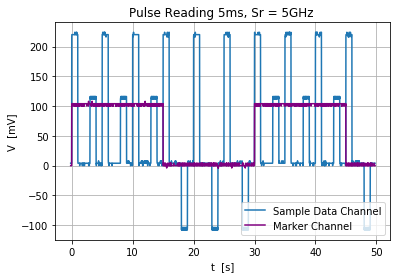

In [80]:
fig,ax= plt.subplots()

ax.grid(True)
plt.plot(Ch1_5GHz.iloc[:,3]*1000,Ch1_5GHz.iloc[:,4]*1000,label= 'Sample Data Channel')
plt.plot(Ch3_5GHz.iloc[:,3]*1000,Ch3_5GHz.iloc[:,4]*10,label= 'Marker Channel',color= 'purple')
ax.set_xlabel('t  [s]')
ax.set_ylabel('V  [mV]')
ax.set_title('Pulse Reading 5ms, Sr = 5GHz ')
ax.legend(loc=4)
plt.show()
fig.savefig('Pulse_reading_5ms_5GHz',optimize=True,bbox_inches='tight')

# 7.2 GHz

In [38]:
Ch1_72GHz = pd.read_csv(r'D:\OneDrive - rwth-aachen.de\RWTH\STM\Pulses\5ms fixed\7.2GHz\ALL0000\F0000CH1.csv')
Ch3_72GHz = pd.read_csv(r'D:\OneDrive - rwth-aachen.de\RWTH\STM\Pulses\5ms fixed\7.2GHz\ALL0000\F0000CH3.csv')

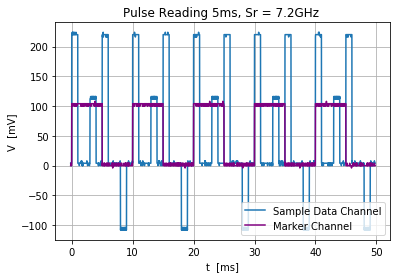

In [79]:
fig,ax= plt.subplots()

ax.grid(True)
plt.plot(Ch1_72GHz.iloc[:,3]*1000,Ch1_72GHz.iloc[:,4]*1000,label= 'Sample Data Channel')
plt.plot(Ch3_72GHz.iloc[:,3]*1000,Ch3_72GHz.iloc[:,4]*10,label= 'Marker Channel',color= 'purple')
ax.set_xlabel('t  [ms]')
ax.set_ylabel('V  [mV]')
ax.set_title('Pulse Reading 5ms, Sr = 7.2GHz ')
ax.legend(loc=4)
plt.show()
fig.savefig('Pulse_reading_5ms_7_2GHz',optimize=True,bbox_inches='tight')

# 125MHz

In [43]:
Ch1_125MHz = pd.read_csv(r'D:\OneDrive - rwth-aachen.de\RWTH\STM\Pulses\5ms fixed\125MHz\F0000CH1.csv')
Ch3_125MHz = pd.read_csv(r'D:\OneDrive - rwth-aachen.de\RWTH\STM\Pulses\5ms fixed\125MHz\F0000CH3.csv')

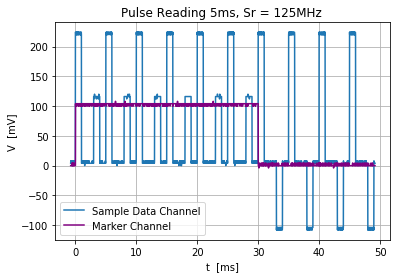

In [77]:
fig,ax= plt.subplots()

ax.grid(True)
plt.plot(Ch1_125MHz.iloc[:,3]*1000,Ch1_125MHz.iloc[:,4]*1000,label= 'Sample Data Channel')
plt.plot(Ch3_125MHz.iloc[:,3]*1000,Ch3_125MHz.iloc[:,4]*10,label= 'Marker Channel',color= 'purple')
ax.set_xlabel('t  [ms]')
ax.set_ylabel('V  [mV]')
ax.set_title('Pulse Reading 5ms, Sr = 125MHz ')
ax.legend(loc=3)
plt.show()
fig.savefig('Pulse_reading_5ms_125MHz',optimize=True,bbox_inches='tight')

# 500MHz

In [82]:
Ch1_500MHz = pd.read_csv(r'D:\OneDrive - rwth-aachen.de\RWTH\STM\Pulses\5ms fixed\500MHz\ALL0000\F0000CH1.csv')
Ch3_500MHz = pd.read_csv(r'D:\OneDrive - rwth-aachen.de\RWTH\STM\Pulses\5ms fixed\500MHz\ALL0000\F0000CH3.csv')

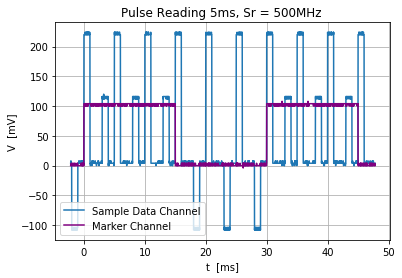

In [83]:
fig,ax= plt.subplots()

ax.grid(True)
plt.plot(Ch1_500MHz.iloc[:,3]*1000,Ch1_500MHz.iloc[:,4]*1000,label= 'Sample Data Channel')
plt.plot(Ch3_500MHz.iloc[:,3]*1000,Ch3_500MHz.iloc[:,4]*10,label= 'Marker Channel',color= 'purple')
ax.set_xlabel('t  [ms]')
ax.set_ylabel('V  [mV]')
ax.set_title('Pulse Reading 5ms, Sr = 500MHz ')
ax.legend(loc=3)
plt.show()
fig.savefig('Pulse_reading_5ms_500MHz',optimize=True,bbox_inches='tight')

# 500MHz Fixed

##  10ms

In [85]:
Ch1_10ms = pd.read_csv(r'D:\OneDrive - rwth-aachen.de\RWTH\STM\Pulses\500Mhz fixed\10ms\ALL0000\F0000CH1.csv')
Ch3_10ms = pd.read_csv(r'D:\OneDrive - rwth-aachen.de\RWTH\STM\Pulses\500Mhz fixed\10ms\ALL0000\F0000CH3.csv')

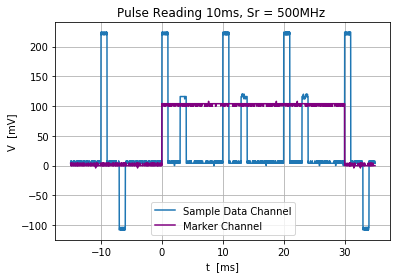

In [91]:

fig,ax= plt.subplots()

ax.grid(True)
plt.plot(Ch1_10ms.iloc[:,3]*1000,Ch1_10ms.iloc[:,4]*1000,label= 'Sample Data Channel')
plt.plot(Ch3_10ms.iloc[:,3]*1000,Ch3_10ms.iloc[:,4]*10,label= 'Marker Channel',color= 'purple')
ax.set_xlabel('t  [ms]')
ax.set_ylabel('V  [mV]')
ax.set_title('Pulse Reading 10ms, Sr = 500MHz ')
ax.legend(loc=8)
plt.show()
fig.savefig('Pulse_reading_10ms_500MHz',optimize=True,bbox_inches='tight')

## 13ms

In [88]:
Ch1_13ms = pd.read_csv(r'D:\OneDrive - rwth-aachen.de\RWTH\STM\Pulses\500Mhz fixed\13ms\ALL0000\F0000CH1.csv')
Ch3_13ms = pd.read_csv(r'D:\OneDrive - rwth-aachen.de\RWTH\STM\Pulses\500Mhz fixed\13ms\ALL0000\F0000CH3.csv')

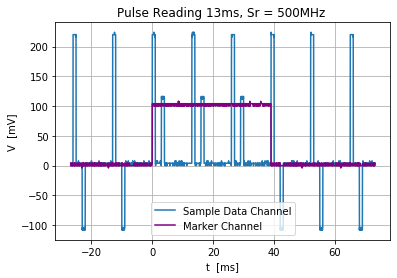

In [128]:

fig,ax= plt.subplots()

ax.grid(True)
x0=Ch1_13ms.iloc[:,3]*1000
x1=Ch3_13ms.iloc[:,3]*1000
plt.plot(x0,Ch1_13ms.iloc[:,4]*1000,label= 'Sample Data Channel')
plt.plot(x1,Ch3_13ms.iloc[:,4]*10,label= 'Marker Channel',color= 'purple')
ax.set_xlabel('t  [ms]')
ax.set_ylabel('V  [mV]')
ax.set_title('Pulse Reading 13ms, Sr = 500MHz ')
ax.legend(loc=8)
plt.show()


#fig.savefig('Pulse_reading_13ms_500MHz',optimize=True,bbox_inches='tight')

## 15ms

In [129]:
Ch1_15ms = pd.read_csv(r'D:\OneDrive - rwth-aachen.de\RWTH\STM\Pulses\500Mhz fixed\15ms\ALL0000\F0000CH1.csv')
Ch3_15ms = pd.read_csv(r'D:\OneDrive - rwth-aachen.de\RWTH\STM\Pulses\500Mhz fixed\15ms\ALL0000\F0000CH3.csv')

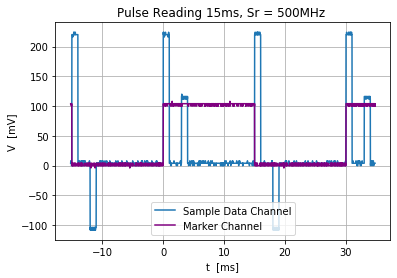

In [130]:

fig,ax= plt.subplots()

ax.grid(True)


plt.plot(Ch1_15ms.iloc[:,3]*1000,Ch1_15ms.iloc[:,4]*1000,label= 'Sample Data Channel')
plt.plot(Ch3_15ms.iloc[:,3]*1000,Ch3_15ms.iloc[:,4]*10,label= 'Marker Channel',color= 'purple')
ax.set_xlabel('t  [ms]')
ax.set_ylabel('V  [mV]')
ax.set_title('Pulse Reading 15ms, Sr = 500MHz ')
ax.legend(loc=8)
plt.show()


fig.savefig('Pulse_reading_15ms_500MHz',optimize=True,bbox_inches='tight')

## 20ms

In [131]:
Ch1_20ms = pd.read_csv(r'D:\OneDrive - rwth-aachen.de\RWTH\STM\Pulses\500Mhz fixed\20ms\ALL0000\F0000CH1.csv')
Ch3_20ms = pd.read_csv(r'D:\OneDrive - rwth-aachen.de\RWTH\STM\Pulses\500Mhz fixed\20ms\ALL0000\F0000CH3.csv')

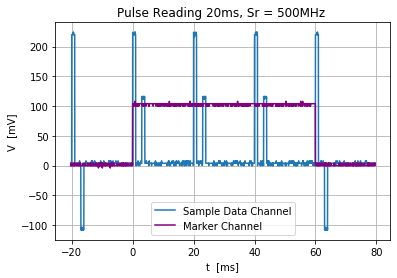

In [132]:
fig,ax= plt.subplots()

ax.grid(True)


plt.plot(Ch1_20ms.iloc[:,3]*1000,Ch1_20ms.iloc[:,4]*1000,label= 'Sample Data Channel')
plt.plot(Ch3_20ms.iloc[:,3]*1000,Ch3_20ms.iloc[:,4]*10,label= 'Marker Channel',color= 'purple')
ax.set_xlabel('t  [ms]')
ax.set_ylabel('V  [mV]')
ax.set_title('Pulse Reading 20ms, Sr = 500MHz ')
ax.legend(loc=8)
plt.show()


fig.savefig('Pulse_reading_20ms_500MHz',optimize=True,bbox_inches='tight')

## 2 loops

In [5]:
Ch1_15ms_500Mhz_l2 = pd.read_csv(r'D:\Alejandro\Pulses\Characterization\Pulses\Different loop number\500Mhz 15ms\2 loops\ALL0000\F0000CH1.csv')
Ch3_15ms_500Mhz_l2 = pd.read_csv(r'D:\Alejandro\Pulses\Characterization\Pulses\Different loop number\500Mhz 15ms\2 loops\ALL0000\F0000CH3.csv')

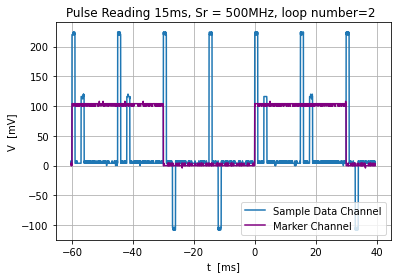

In [9]:
fig,ax= plt.subplots()

ax.grid(True)


plt.plot(Ch1_15ms_500Mhz_l2 .iloc[:,3]*1000,Ch1_15ms_500Mhz_l2 .iloc[:,4]*1000,label= 'Sample Data Channel')
plt.plot(Ch3_15ms_500Mhz_l2.iloc[:,3]*1000,Ch3_15ms_500Mhz_l2.iloc[:,4]*10,label= 'Marker Channel',color= 'purple')
ax.set_xlabel('t  [ms]')
ax.set_ylabel('V  [mV]')
ax.set_title('Pulse Reading 15ms, Sr = 500MHz, loop number=2 ')
ax.legend(loc=4)
plt.show()


fig.savefig('Pulse_reading_15ms_500MHz_l2',bbox_inches='tight')

## 3  loops

In [2]:
Ch1_15ms_500Mhz_l3 = pd.read_csv(r'D:\OneDrive - rwth-aachen.de\RWTH\STM\Pulses\Different loop number\500Mhz 15ms\3 loops\ALL0000\F0000CH1.csv')
Ch3_15ms_500Mhz_l3 = pd.read_csv(r'D:\OneDrive - rwth-aachen.de\RWTH\STM\Pulses\Different loop number\500Mhz 15ms\3 loops\ALL0000\F0000CH3.csv')

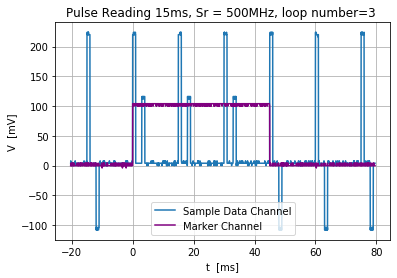

In [4]:
fig,ax= plt.subplots()

ax.grid(True)


plt.plot(Ch1_15ms_500Mhz_l3 .iloc[:,3]*1000,Ch1_15ms_500Mhz_l3 .iloc[:,4]*1000,label= 'Sample Data Channel')
plt.plot(Ch3_15ms_500Mhz_l3.iloc[:,3]*1000,Ch3_15ms_500Mhz_l3.iloc[:,4]*10,label= 'Marker Channel',color= 'purple')
ax.set_xlabel('t  [ms]')
ax.set_ylabel('V  [mV]')
ax.set_title('Pulse Reading 15ms, Sr = 500MHz, loop number=3 ')
ax.legend(loc=8)
plt.show()


fig.savefig('Pulse_reading_15ms_500MHz_l3',optimize=True,bbox_inches='tight')

5ms 500MHz, 2 loops

In [10]:


Ch1_5ms_500Mhz_l2 = pd.read_csv(r'D:\Alejandro\Pulses\Characterization\Pulses\Different loop number\500MHz 5ms\2 loops\ALL0000\F0000CH1.csv')
Ch3_5ms_500Mhz_l2 = pd.read_csv(r'D:\Alejandro\Pulses\Characterization\Pulses\Different loop number\500MHz 5ms\2 loops\ALL0000\F0000CH3.csv')

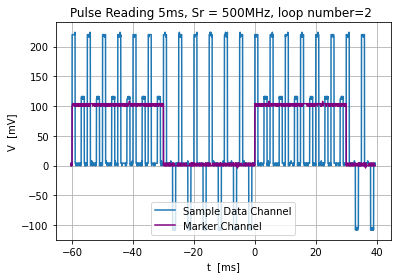

In [11]:
fig,ax= plt.subplots()

ax.grid(True)


plt.plot(Ch1_5ms_500Mhz_l2 .iloc[:,3]*1000,Ch1_5ms_500Mhz_l2 .iloc[:,4]*1000,label= 'Sample Data Channel')
plt.plot(Ch3_5ms_500Mhz_l2.iloc[:,3]*1000,Ch3_5ms_500Mhz_l2.iloc[:,4]*10,label= 'Marker Channel',color= 'purple')
ax.set_xlabel('t  [ms]')
ax.set_ylabel('V  [mV]')
ax.set_title('Pulse Reading 5ms, Sr = 500MHz, loop number=2 ')
ax.legend(loc=8)
plt.show()


fig.savefig('Pulse_reading_5ms_500MHz_l2',bbox_inches='tight')

3 loops , 500MHz, 5ms

In [13]:
Ch1_5ms_500Mhz_l3 = pd.read_csv(r'D:\Alejandro\Pulses\Characterization\Pulses\Different loop number\500MHz 5ms\3 loops\ALL0000\F0000CH1.csv')
Ch3_5ms_500Mhz_l3 = pd.read_csv(r'D:\Alejandro\Pulses\Characterization\Pulses\Different loop number\500MHz 5ms\3 loops\ALL0000\F0000CH3.csv')

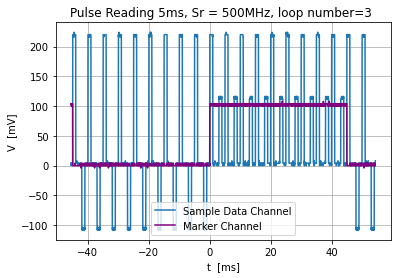

In [14]:
fig,ax= plt.subplots()

ax.grid(True)


plt.plot(Ch1_5ms_500Mhz_l3 .iloc[:,3]*1000,Ch1_5ms_500Mhz_l3 .iloc[:,4]*1000,label= 'Sample Data Channel')
plt.plot(Ch3_5ms_500Mhz_l3.iloc[:,3]*1000,Ch3_5ms_500Mhz_l3.iloc[:,4]*10,label= 'Marker Channel',color= 'purple')
ax.set_xlabel('t  [ms]')
ax.set_ylabel('V  [mV]')
ax.set_title('Pulse Reading 5ms, Sr = 500MHz, loop number=3 ')
ax.legend(loc=8)
plt.show()


fig.savefig('Pulse_reading_5ms_500MHz_l3',bbox_inches='tight')

## 6GHz

In [15]:
Ch1_5ms_6GHz = pd.read_csv(r'D:\Alejandro\Pulses\Characterization\Pulses\5ms fixed\6GHz\ALL0000\F0000CH1.csv')
Ch3_5ms_6GHz = pd.read_csv(r'D:\Alejandro\Pulses\Characterization\Pulses\5ms fixed\6GHz\ALL0000\F0000CH3.csv')

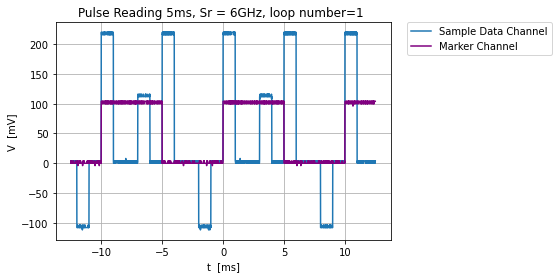

In [21]:
fig,ax= plt.subplots()

ax.grid(True)


plt.plot(Ch1_5ms_6GHz.iloc[:,3]*1000,Ch1_5ms_6GHz.iloc[:,4]*1000,label= 'Sample Data Channel')
plt.plot(Ch3_5ms_6GHz.iloc[:,3]*1000,Ch3_5ms_6GHz.iloc[:,4]*10,label= 'Marker Channel',color= 'purple')
ax.set_xlabel('t  [ms]')
ax.set_ylabel('V  [mV]')
ax.set_title('Pulse Reading 5ms, Sr = 6GHz, loop number=1 ')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()


fig.savefig('Pulse_reading_5ms_6GHz',bbox_inches='tight')

# Amplitude Issue 15ms 500Mhz

In [3]:
Ch1_15ms = pd.read_csv(r'D:\OneDrive - rwth-aachen.de\RWTH\STM\Pulses\500Mhz fixed\15ms\ALL0000\F0000CH1.csv')
Ch3_15ms = pd.read_csv(r'D:\OneDrive - rwth-aachen.de\RWTH\STM\Pulses\500Mhz fixed\15ms\ALL0000\F0000CH3.csv')

In [2]:
start = time.time()

pl, tim= Sweept(Pulses_List,10,2,15,7500000)
pln, tim= Sweept(Pulses_List2,10,2,15,7500000)

#SeqL(M8190A,pl,pln,AWG_S1,2,1)

end = time.time()

print(end - start)

143.09130930900574


In [3]:
aname, a = CSV_PD(pl,AWG_S3,1,2)
bname, b = CSV_PD(pln,AWG_S3,0,2)

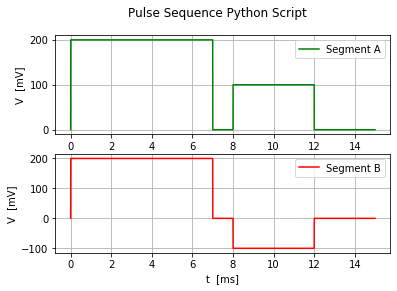

In [4]:
fig,ax= plt.subplots(2)

ax[0].grid(True)
ax[1].grid(True)
fig.suptitle('Pulse Sequence Python Script')

ax[0].plot(tim,pl,'-g',label= 'Segment A')
ax[1].plot(tim,pln,'-r',label= 'Segment B')
ax[0].set_ylabel('V  [mV]')
ax[1].set_ylabel('V  [mV]')
ax[0].set_xlabel('t  [ms]')
ax[1].set_xlabel('t  [ms]')

#ax[0].set_title(' Pulse Sequence Python Script ')

ax[0].legend(loc=0)
ax[1].legend(loc=0)
plt.show()
fig.savefig('PulseSequence_15ms_500Mhz_Python_Script_6',optimize=True,bbox_inches='tight')

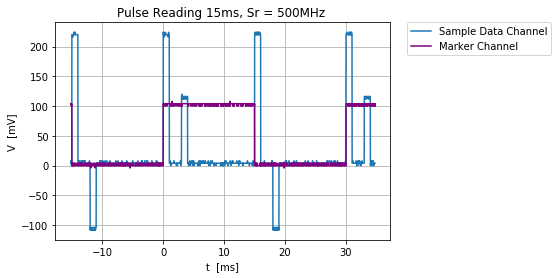

In [5]:

fig,ax= plt.subplots()

ax.grid(True)


plt.plot(Ch1_15ms.iloc[:,3]*1000,Ch1_15ms.iloc[:,4]*1000,label= 'Sample Data Channel')
plt.plot(Ch3_15ms.iloc[:,3]*1000,Ch3_15ms.iloc[:,4]*10,label= 'Marker Channel',color= 'purple')
ax.set_xlabel('t  [ms]')
ax.set_ylabel('V  [mV]')
ax.set_title('Pulse Reading 15ms, Sr = 500MHz ')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()


fig.savefig('Pulse_reading_15ms_500MHz',optimize=True,bbox_inches='tight')

In [8]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

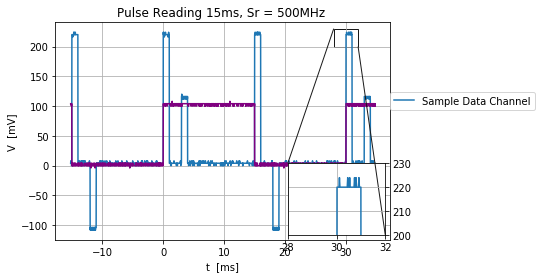

In [43]:
fig,ax= plt.subplots()


ax.grid(True)

plt.plot(Ch1_15ms.iloc[:,3]*1000,Ch1_15ms.iloc[:,4]*1000,label= 'Sample Data Channel')
plt.plot(Ch3_15ms.iloc[:,3]*1000,Ch3_15ms.iloc[:,4]*10,label= 'Marker Channel',color= 'purple')


axins = zoomed_inset_axes(ax, 4, loc=4)  # creates the inset box with the zoom-factor: 2.5, location: upper-right

axins.grid(True)
plt.plot(Ch1_15ms.iloc[:,3]*1000,Ch1_15ms.iloc[:,4]*1000,label= 'Sample Data Channel')

x1, x2, y1, y2 = 28, 32, 200, 230 # specify the limits within the values of the main plot that you are interested
                                    # in this example the region goes from x=[-2.5, -1.9] and y=[2.5, 3.5]
    
axins.set_xlim(x1, x2) # apply the x-limits
axins.set_ylim(y1, y2) # apply the y-limits

#mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5",lw=4) #adds the lines that indicates the zoomed region

axins.yaxis.tick_right()
#plt.yticks(visible=False) #hides the axes info of the inset
#plt.xticks(visible=False) # same as line above

ax.set_ylabel('V  [mV]')
ax.set_xlabel('t  [ms]')
ax.set_title('Pulse Reading 15ms, Sr = 500MHz ')
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.1")

plt.legend(bbox_to_anchor=(1.05, 2), loc='upper left', borderaxespad=0.)
#plt.savefig("zoom.png",optimize=True,bbox_inches='tight')

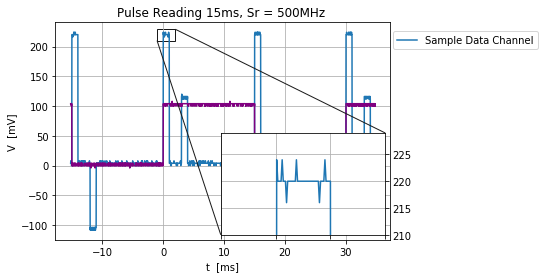

In [62]:
fig,ax= plt.subplots()


ax.grid(True)

plt.plot(Ch1_15ms.iloc[:,3]*1000,Ch1_15ms.iloc[:,4]*1000,label= 'Sample Data Channel')
plt.plot(Ch3_15ms.iloc[:,3]*1000,Ch3_15ms.iloc[:,4]*10,label= 'Marker Channel',color= 'purple')


axins = zoomed_inset_axes(ax, 9, loc=4)  # creates the inset box with the zoom-factor: 2.5, location: upper-right

axins.grid(True)
plt.plot(Ch1_15ms.iloc[:,3]*1000,Ch1_15ms.iloc[:,4]*1000,label= 'Sample Data Channel')

x1, x2, y1, y2 = -1, 2, 210, 229 # specify the limits within the values of the main plot that you are interested
                                    # in this example the region goes from x=[-2.5, -1.9] and y=[2.5, 3.5]
    
axins.set_xlim(x1, x2) # apply the x-limits
axins.set_ylim(y1, y2) # apply the y-limits

#mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5",lw=4) #adds the lines that indicates the zoomed region

axins.yaxis.tick_right()
#plt.yticks(visible=False) #hides the axes info of the inset
plt.xticks(visible=False) # same as line above

ax.set_ylabel('V  [mV]')
ax.set_xlabel('t  [ms]')
ax.set_title('Pulse Reading 15ms, Sr = 500MHz ')
mark_inset(ax, axins, loc1=3, loc2=1, fc="none", ec="0.1")

plt.legend(bbox_to_anchor=(1.05, 2), loc='upper left', borderaxespad=0.)
plt.savefig("zoom.png",optimize=True,bbox_inches='tight')